# How to retrieve data, analyse, and plot tco3 plots (jupyter)

This tutorial shows how to use a Jupyter notebook to retrieve **skimmed data** points in the JSON format and analyse for either **tco3_zm** or **tco3_return** plot. The Jupyter notebook can be downloaded from [here](https://git.scc.kit.edu/synergy.o3as/o3docs/-/blob/master/user/jupyter/o3api_data+analysis_tco3.ipynb).

## System installations
If necessary, install required libraries or python packages 

In [1]:
### If needed, install additional modules:
#!pip3 install pandas
#!pip3 install matplotlib
### interactive plotting in jupyterlab requires node.js (pip does not install it!!):
#!apt update && apt install -y nodejs
#!pip3 install ipympl
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager
#!jupyter labextension install jupyter-matplotlib
#!jupyter nbextension enable --py widgetsnbextension
### DON'T FORGET TO RESTART JupyterLab !!
# start jupyterlab:
# jupyter lab --ip=0.0.0.0

## Import necessary packages
In this tutorial we need the following python packages:

[json](https://docs.python.org/3/library/json.html) - to decode JSON data

[matplotlib](https://matplotlib.org/) - to plot the data

[numpy](https://numpy.org/) and [pandas](https://pandas.pydata.org/) - to manipulate the data

[os](https://docs.python.org/3/library/os.html) - to manipulate URL paths

[requests](https://docs.python-requests.org/en/latest/) - to communicate with the O3as API and retrieve data

[scipy](https://scipy.org/) - to apply boxcar smoothing on the skimmed data

In [2]:
import json
import matplotlib.style as mplstyle
mplstyle.use('fast')
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
from scipy import signal

## Define global variables
we set a few variables: e.g. the base URL of O3AS API and the default figure size 

In [3]:
debug = False  # global debug flag, set to True to get more print-outs

pd.options.display.max_columns = None  # prints all columns of the pandas' DataFrame

# for interactive plot, may change to widget, if installed
%matplotlib inline

# Set default size of plots
plt.rcParams['figure.figsize'] = [12, 8]

# A few variables needed for every REST API call:
url_o3api = "http://api.o3as.fedcloud.eu/api/v1/"  # base URL of the O3as API
headers = {'Content-Type': 'application/json',
           'Accept': 'application/json'}

# Define Reference Measurement and Reference Year
refMeasurement = 'SBUV_GSFC_merged-SAT-ozone'
refYear = 1980

## Retrieve list of models
We will analyse refC2 models, therefore we first request the list of corresponding models via the REST API

In [4]:
# Use '/models' API Endpoint, i.e. append "models" to the base url_o3api:
url_o3api_tco3_zm_models = os.path.join(url_o3api, "models")

# request the list of modesl from O3as API, select "refC2" models:
tco3_zm_models = requests.request("GET",
                                  url=url_o3api_tco3_zm_models,
                                  params={'select': 'refc2'},
                                  headers=headers).json()
print(tco3_zm_models)

['CCMI-1_ACCESS_ACCESS-CCM-refC2', 'CCMI-1_CCCma_CMAM-refC2', 'CCMI-1_CESM1-CAM4Chem_refC2_r1i1p1', 'CCMI-1_CESM1-CAM4Chem_refC2_r2i1p1', 'CCMI-1_CESM1-CAM4Chem_refC2_r3i1p1', 'CCMI-1_CESM1-WACCM_refC2_r1i1p1', 'CCMI-1_CESM1-WACCM_refC2_r2i1p1', 'CCMI-1_CESM1-WACCM_refC2_r3i1p1', 'CCMI-1_CHASER-MIROC-ESM-refC2', 'CCMI-1_CNRM-CERFACS_CNRM-CM5-3-refC2', 'CCMI-1_CNRM-CERFACS_MOCAGE-refC2', 'CCMI-1_ETH-PMOD_SOCOL3-refC2', 'CCMI-1_GSFC_GEOSCCM-refC2', 'CCMI-1_MESSy_EMAC-L90MA-refC2', 'CCMI-1_MOHC_HadGEM3-ES-refC2', 'CCMI-1_MRI_ESM1r1-refC2', 'CCMI-1_NIES_CCSRNIES-MIROC3.2-refC2', 'CCMI-1_NIWA_NIWA-UKCA-refC2', 'CCMI-1_U-CAMBRIDGE_UMUKCA-UCAM-refC2', 'CCMI-1_U-LAQUILA_CCM-refC2', 'CCMI-1_U-LEEDS_UMSLIMCAT-refC2']


We also add a reference measurement, **refMeasurement** (defined above, e.g. SBUV_GSFC_merged-SAT-ozone), to the list of models to be plotted

In [5]:
tco3_zm_models.append(refMeasurement)

## Request skimmed data to analyse and to build tco3 plots

1.    we configure parameters of interest to get the data. In the example we specify that we want a plot for:

*   Range of years: (1960, 2100)
*   month: September, October, November
*   South Hemisphere (SH, latitudes: -90, -60)

In [6]:
# initialize an empty dictionary
kwargs_tco3_zm = {}
 
# Build kwargs with tco3_zm parameters for O3as API '/data' Endpoint. 
# Keys have to correspond to expected by the API keys!

kwargs_tco3_zm = {
    'begin'   : 1960,
    'end'     : 2100,
    'month'   : '9,10,11',
    'lat_min' : -90,
    'lat_max' : -60
}

2.  We want to retrieve skimmed data to analyse and build "tco3_zm" plot: we use **'/data'** endpoint, plot type **'tco3_zm'**, therefore we append **'data/tco3_zm'** to the base URL of the O3as API

3. Then we retrieve skimmed data for the tco3_zm plot for the parameters of interest and the list of refC2 models defined above







In [7]:
# Build the API URL, use /data/tco3_zm endpoint:
url_o3api_data_tco3_zm = os.path.join(url_o3api, "data/tco3_zm")

# Request data
response = requests.request("POST",
                            url=url_o3api_data_tco3_zm,
                            params=kwargs_tco3_zm,
                            headers=headers,
                            data=json.dumps(tco3_zm_models))
if debug: print(response.request.url)  # debug: print the configured API call

# Read the status_code. Normal response => 200
print(response.status_code)
tco3_skim_data = response.json()
print(tco3_skim_data[:5])  # print first five for cross-checking

200
[{'legalinfo': 'https://o3as.data.kit.edu/policies/terms-of-use.html', 'model': 'CCMI-1_ACCESS_ACCESS-CCM-refC2', 'plotstyle': {'color': 'purple', 'linestyle': 'solid', 'marker': 'o'}, 'x': ['1960-09-16 00:00:00', '1960-10-16 00:00:00', '1960-11-16 00:00:00', '1961-09-16 00:00:00', '1961-10-16 00:00:00', '1961-11-16 00:00:00', '1962-09-16 00:00:00', '1962-10-16 00:00:00', '1962-11-16 00:00:00', '1963-09-16 00:00:00', '1963-10-16 00:00:00', '1963-11-16 00:00:00', '1964-09-16 00:00:00', '1964-10-16 00:00:00', '1964-11-16 00:00:00', '1965-09-16 00:00:00', '1965-10-16 00:00:00', '1965-11-16 00:00:00', '1966-09-16 00:00:00', '1966-10-16 00:00:00', '1966-11-16 00:00:00', '1967-09-16 00:00:00', '1967-10-16 00:00:00', '1967-11-16 00:00:00', '1968-09-16 00:00:00', '1968-10-16 00:00:00', '1968-11-16 00:00:00', '1969-09-16 00:00:00', '1969-10-16 00:00:00', '1969-11-16 00:00:00', '1970-09-16 00:00:00', '1970-10-16 00:00:00', '1970-11-16 00:00:00', '1971-09-16 00:00:00', '1971-10-16 00:00:00', 

4.  The received JSON data are converted into pandas Dataframe for an easier data manipulation

In [8]:
tco3_skim_pd = pd.json_normalize(tco3_skim_data)
if debug: print(tco3_skim_pd.head())

5. Let's plot the retrieved skimmed data:

Text(0, 0.5, 'tco3_zm (DU)')

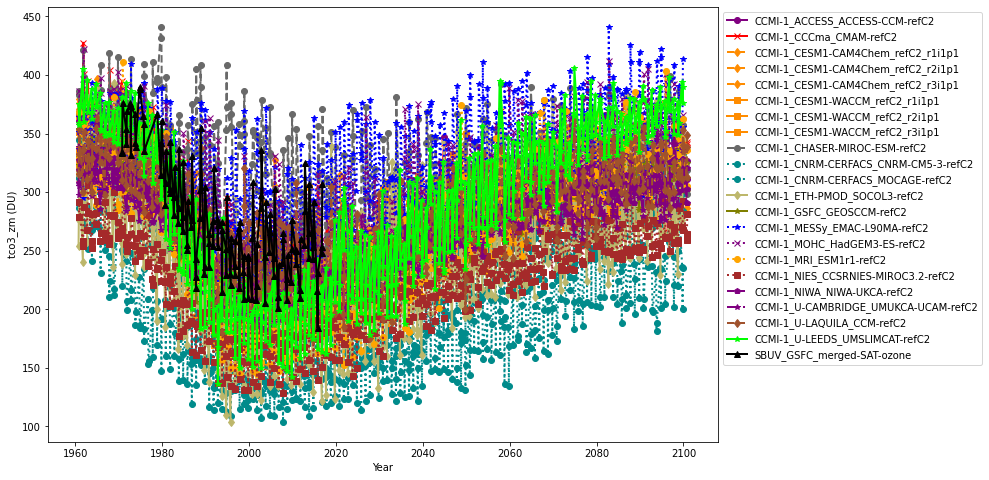

In [9]:
# set default linewidth:
linewidth_default = 2
if not 'plotstyle.linewidth' in tco3_skim_pd.columns:
  tco3_skim_pd['plotstyle.linewidth'] = linewidth_default

# plot every model
for index, c in tco3_skim_pd.iterrows():
  plt.plot(pd.to_datetime(c['x']), c['y'], label=c['model'],
           color=c['plotstyle.color'], linestyle=c['plotstyle.linestyle'], 
           marker=c['plotstyle.marker'], linewidth=c['plotstyle.linewidth'])

# show the legend
ax = plt.gca() # get axis instance
ax.legend(bbox_to_anchor=(1.0, 1.0))

# put titels for axes
plt.xlabel('Year')
plt.ylabel('tco3_zm (DU)')

## Analyse the skimmed data and plot tco3_zm

To analyse the data and produce tco3_zm plot, we do:

1.   Define a help function for boxcar smoothing
2.   Transform the Pandas Dataframe for easier data manipulation
3.   Average skimmed data over one year
4.   Apply boxcar smoothing, keep the reference year as-it-is, i.e. without smoothing
5.   For the reference year, find the TCO3 value in the measured data (reference value)
6.   Find biases in the simulation data in relation to the reference year
7.   Shift all simulations to the reference value at the reference year
8.   Plot shifted models together with the reference value.

### Define a help function for boxcar smoothing

In [10]:
def boxcar(data, bwin):
  """Function to apply boxcar, following
  https://scipy-cookbook.readthedocs.io/items/SignalSmooth.html
  N.B. 'valid' replaced with 'same' !

  :param data: input data
  :param bwin: width of the boxcar window
  :return boxcar_values: smoothed values
  """
  debug_boxcar = False

  boxcar = np.ones(bwin)

  if debug_boxcar: print("signal(raw) (len={}): {}".format(len(data),data))

  # mirror start and end of the original signal:
  sgnl = np.r_[data[bwin-1:0:-1],data,data[-2:-bwin-1:-1]]
  boxcar_values = signal.convolve(sgnl,
                                  boxcar, 
                                  mode='same')/bwin
  if debug_boxcar: print("signal (len={}): {}".format(len(sgnl),sgnl))
  if debug_boxcar: print("signal+boxcar (len={}): {}".format(len(boxcar_values),
                                                             boxcar_values))
  return boxcar_values[bwin-1:-(bwin-1)]

### Transform the DataFrame

In [11]:
tco3_zm_pd = pd.DataFrame({'time': pd.to_datetime(tco3_skim_pd.loc[0,'x']),
                           tco3_skim_pd.loc[0,'model']: tco3_skim_pd.loc[0,'y']})

for i in range(1, len(tco3_skim_pd)):
  curve = pd.DataFrame({'time': pd.to_datetime(tco3_skim_pd.loc[i,'x']),
                        tco3_skim_pd.loc[i,'model']: tco3_skim_pd.loc[i,'y']})
  tco3_zm_pd = tco3_zm_pd.merge(curve, how='outer', on=['time'], sort=True)

tco3_zm_pd = tco3_zm_pd.set_index('time')
tco3_zm_pd = tco3_zm_pd.replace({0: np.nan})

# print(tco3_zm_pd.head()) # uncomment if you like to see the created DataFrame

### Average data over one year

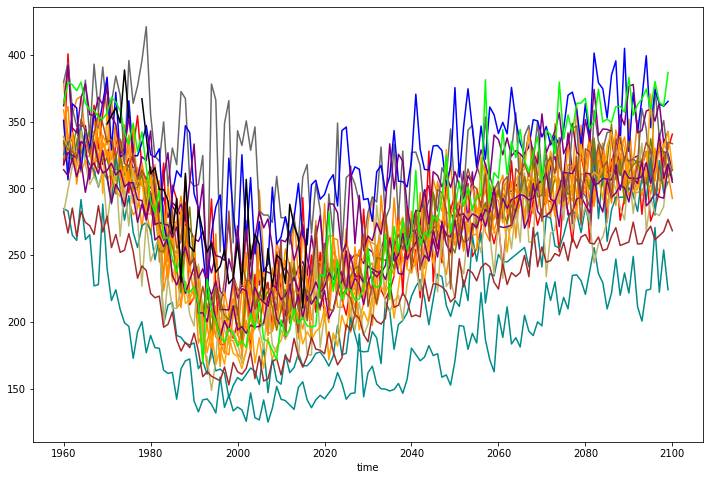

In [12]:
# Average model data per year, index -> year
tco3_zm_year_pd = tco3_zm_pd.groupby([tco3_zm_pd.index.year]).mean()

# we may use pandas.plot() immediately
# Optionally, we can set matplotlib colors to the default values specified by the API:
import matplotlib as mpl
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=tco3_skim_pd['plotstyle.color'].values)

tco3_zm_year_pd.plot(legend=False)

### Apply boxcar smoothing

we use 10-point boxcar smoothing, when applied after averaging per year, it is an equivalent of 10-years

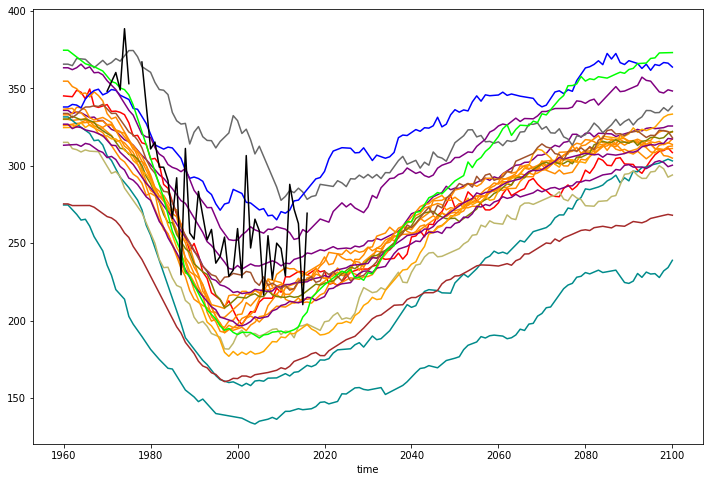

In [13]:
boxcar_window = 10 # boxcar window for smoothing

# different models may have data point until a different year
# if last years have NaNs fill them with "before NaN values"
last_year = tco3_zm_year_pd.index.values[-1]
tco3_zm_year_pd[tco3_zm_year_pd.index > (last_year - boxcar_window)] = tco3_zm_year_pd[tco3_zm_year_pd.index > (last_year - boxcar_window)].fillna(method='ffill')

# apply boxcar smoothing
tco3_zm_smooth_pd = tco3_zm_year_pd.apply(boxcar, args = [boxcar_window], axis = 0, result_type = 'broadcast')

# inject the reference measurement (refMeasurement) as-it-is, i.e. **without** smoothing
if refMeasurement in tco3_zm_smooth_pd.columns:
  tco3_zm_smooth_pd[refMeasurement] = tco3_zm_year_pd[refMeasurement]

# plot smoothed data
tco3_zm_smooth_pd.plot(legend=False)

All models are quite apart. We can choose a reference value, i.e. TCO3 value for the reference year (see "refYear" in the "Global Variables") and the reference measurement ("refMeasurement") and shift all models to that value.

### Find TCO3 value for the reference measurement (refMeasurement) and reference year (refYear)

In [14]:
refValue = tco3_zm_year_pd[refMeasurement][tco3_zm_year_pd.index == refYear].interpolate(method='linear').values[0]
print(refValue)

310.925


### Shift models to the reference value (refValue)

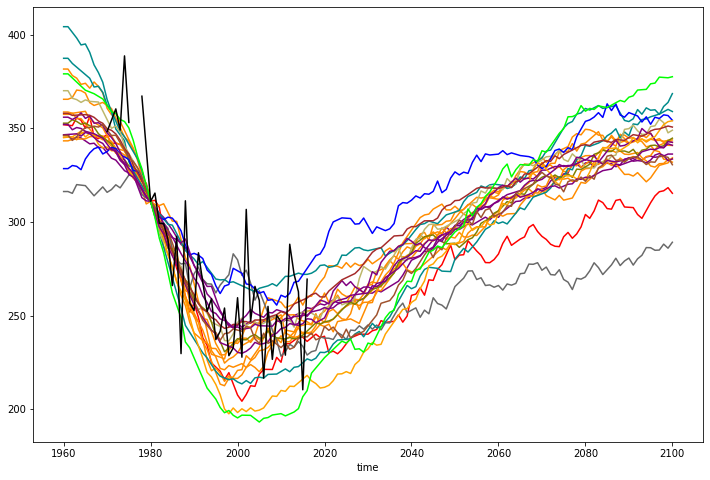

In [15]:
# Calculate shift values for every model (refValue - modelValue for refYear)
tco3_zm_shift = refValue - tco3_zm_smooth_pd[tco3_zm_smooth_pd.index == refYear]

# Shift models by the shift values
tco3_zm_refYear = tco3_zm_smooth_pd + tco3_zm_shift.values

tco3_zm_refYear.plot(legend=False)

In [16]:
# Create an empty DataFrame for statistics (also to have better control how to plot it later)
tco3_zm_refYear_stat = pd.DataFrame(index=tco3_zm_refYear.index, columns=['Mean', 'Std', 'Median'])
# Fill 'Mean', 'Std' values, skip refMeasurement from the 'Mean' and 'Std' calculations
tco3_zm_refYear_stat["Mean"] = tco3_zm_refYear.drop(refMeasurement, axis=1, inplace=False).mean(axis=1, skipna=True)
tco3_zm_refYear_stat["Std"] = tco3_zm_refYear.drop(refMeasurement, axis=1, inplace=False).std(axis=1, skipna=True)
tco3_zm_refYear_stat["Mean-Std"] = tco3_zm_refYear_stat["Mean"] - tco3_zm_refYear_stat["Std"]
tco3_zm_refYear_stat["Mean+Std"] = tco3_zm_refYear_stat["Mean"] + tco3_zm_refYear_stat["Std"]
tco3_zm_refYear_stat["Median"] = tco3_zm_refYear.median(axis=1, skipna=True)

### Finally, plot tco3_zm analysed data

Text(0, 0.5, 'tco3_zm (DU)')

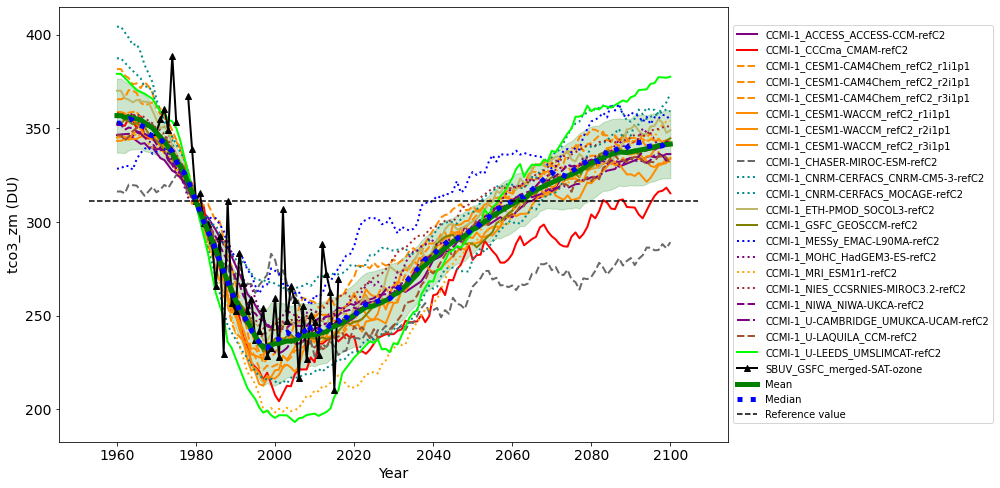

In [17]:
# one can use pandas.plot() but if we want to use default styles delivered by the API, we better plot line-by-line
# for the tco3_zm plot we do not use "marker" except for the reference measurement

for col in tco3_zm_refYear.columns:
  style = tco3_skim_pd[tco3_skim_pd['model']==col]
  col_marker = '' if col != refMeasurement else style['plotstyle.marker'].values[0]
  tco3_zm_refYear[col].plot(color=style['plotstyle.color'].values[0], 
                            linestyle=style['plotstyle.linestyle'].values[0], 
                            marker=col_marker, 
                            linewidth=style['plotstyle.linewidth'].values[0])

# draw horizonthal line for the reference value (refValue)
xmin, xmax = plt.xlim()
plt.hlines(refValue, xmin, xmax, 
           colors='k', # 'dimgray'..? 
           linestyles='dashed',
           label='Reference value',
           zorder=256)

# plot Mean, Median, and fill the area between Mean +/- Std
tco3_zm_refYear_stat['Mean'].plot(linewidth=5, color='g')
plt.fill_between(tco3_zm_refYear_stat.index,
                 tco3_zm_refYear_stat['Mean+Std'], 
                 tco3_zm_refYear_stat['Mean-Std'], 
                 color='g', alpha=0.2);
tco3_zm_refYear_stat['Median'].plot(linewidth=5, linestyle='dotted', color='b') # dashed

# tune the plot
ax = plt.gca() # get axis instance
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles,
           loc='center left',
           bbox_to_anchor=(1.0, 0.5))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax.set_xlabel('Year', fontsize='x-large')
ax.set_ylabel('tco3_zm (DU)', fontsize='x-large')

## Further analyse the data and plot tco3_return

### Define a help function to find return year for every model

In [18]:
def get_tco3_return(data):
  """Function to find return_years for the set of models

  :param data: input climate data after smoothing and shifting to the reference point
  :return tco3_return_year_pd: DataFrame of models with return years
  """

  refMargin = 5 # 'margin' years after refYear to avoid return years immediately after refYear
  # select data later than (refYear+refMargin) year and with values above refValue. Drop duplicates to remove raws with all False or True
  tco3_return = (data[data.index>(refYear+refMargin)]>refValue).drop_duplicates()
  # every model (column) with at least one return_year (True) add to the dictionary { 'model': return_year}
  tco3_return_year = { col: [tco3_return[col][tco3_return[col]==True].index[0]] for col in tco3_return.columns if len(tco3_return[col][tco3_return[col]==True].index)>0 }
  # convert tco3_return_year dictionary to the pandas DataFrame
  tco3_return_year_pd = pd.DataFrame.from_dict(tco3_return_year)
  tco3_return_year_pd.index = ['user_region']

  return tco3_return_year_pd

### Find return years for specified models

In [19]:
# find return years for the models, exclude the Reference Measurement (refMeasurement)
tco3_return_models = get_tco3_return(tco3_zm_refYear.drop(refMeasurement, axis=1))
if debug: print(tco3_return_models)

# find return years for statistical data points ('Mean', 'Mean-Std', 'Mean+Std')
tco3_return_stat = get_tco3_return(tco3_zm_refYear_stat)
if debug: print(tco3_return_stat)

### Finally, plot the return years, tco3_return

Text(0, 0.5, 'tco3_zm return year')

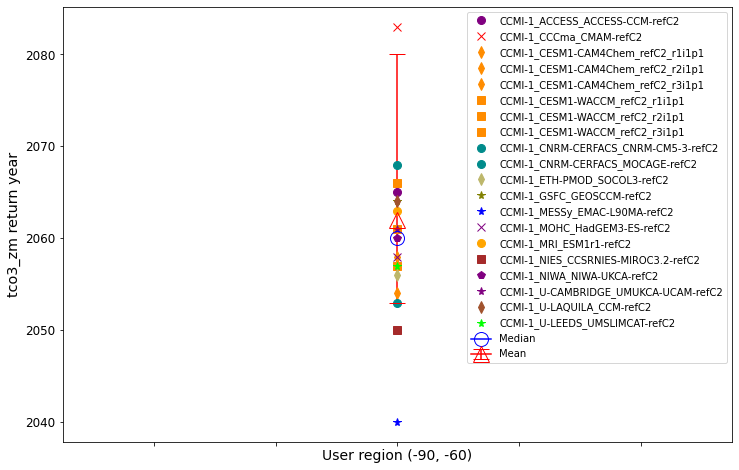

In [20]:
xlabel = F"User region ({kwargs_tco3_zm['lat_min']}, {kwargs_tco3_zm['lat_max']})"
tco3_return_models.index = [xlabel]

# to use default styles delivered by the API, we plot model-by-model
for col in tco3_return_models.columns:
  style = tco3_skim_pd[tco3_skim_pd['model']==col]
  tco3_return_models[col].plot(color=style['plotstyle.color'].values[0], 
                               linestyle='none', 
                               marker=style['plotstyle.marker'].values[0],
                               markersize=8)

mean_yerr = [ tco3_return_stat['Mean'] - tco3_return_stat['Mean+Std'],
              tco3_return_stat['Mean-Std'] - tco3_return_stat['Mean']]
tco3_return_stat.index = [xlabel]
tco3_return_stat['Mean'].plot(color='r', marker='^', markersize=16, yerr=mean_yerr, capsize=8, legend='Mean', mfc='None')
tco3_return_stat['Median'].plot(color='b', marker='o', markersize=14, legend='Median', mfc='None')

# tune the plot
# show the legend
ax = plt.gca() # get axis instance
ax.legend(bbox_to_anchor=(1.0, 1.0))

plt.xticks(fontsize=14)
plt.yticks(fontsize=12)

ax.set_ylabel('tco3_zm return year', fontsize='x-large')